# Example: Let's Build a Hopfield Network and Memorize Some Stuff
This example will familiarize students with the construction and analysis of [Hopfield networks](https://en.wikipedia.org/wiki/Hopfield_network), a form of an artificial neural network consists of a single layer of neurons, where each neuron is connected to every other neuron except itself. 

## Setup
This example requires several external libraries and a function to compute the outer product. Let's download and install these packages and call our `Include.jl` file.

In [3]:
include("Include.jl");

In [4]:
file_extension(file::String) = file[findlast(==('.'), file)+1:end];

## Prerequisites
We need to construct two datasets before training and testing the Hopfield network. First, we need to build a `training dataset` of images that we will use to estimate the model parameters. We'll save training data in the `training_image_dataset` variable. Next, we'll construct a `test dataset,` which we'll use to see how well our `ANN` predicts data it has never seen. We'll save this data in the `testing_image_dataset` variable.
* Both the `training_image_dataset` and `testing_image_dataset` will be of type `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` where the first element is the input data `x.` The second element is the `label,` i.e., whether the image corresponds to `0,....,9`.
* The `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` type has a couple of weird features. First, notice that the floating point is `Float32`, not the default `Float64`. Next, the labels are [One Hot ecoded](https://en.wikipedia.org/wiki/One-hot). Finally, the input data `x` is a Vector, not a Matrix (even though the original image is a matrix of `Gray` values).

### Select a set of `training` images, and build the `training_image_dataset`
`Unhide` the code blocks below to see how we construct and populate the `training_image_dataset` variable. First, we load all the images into the `training_image_dictionary::Dict{Int64, Array{Gray{N0f8},3}}`, and then convert these to a vector vector format.

In [7]:
number_of_training_examples = 3000;
number_digit_array = range(0,length=10,step=1) |> collect;
training_image_dictionary = Dict{Int64, Array{Gray{N0f8},3}}();
for i ∈ number_digit_array
    
    # create a set for this digit -
    image_digit_array = Array{Gray{N0f8},3}(undef, 28, 28, number_of_training_examples);
    files = readdir(joinpath(_PATH_TO_IMAGES,"$(i)")); 
    imagecount = 1;
    for fileindex ∈ 1:number_of_training_examples
        filename = files[fileindex];
        ext = file_extension(filename)
        if (ext == "jpg")
            image_digit_array[:,:,fileindex] = joinpath(_PATH_TO_IMAGES, "$(i)", filename) |> x-> FileIO.load(x);
            imagecount += 1
        end
    end

    # capture -
    training_image_dictionary[i] = image_digit_array
end

Next, we take the images and vectorize them. Each $N\times{N}$ image array is linearized, i.e., the $N\times{N}$ array containing the grayscale values at each pixel is converted to an $N^{2}$ vector of values. What image class, i.e., what number it represents, is then converted to [one-hot format](https://en.wikipedia.org/wiki/One-hot). The converted data is stored in the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable.
* __What's the deal with Float32__? Most neural network libraries (or other machine learning calculations) use `Float32` (or lower) to save memory space because of the large number of parameters associated with the network. Additionally, model training is often carried out using specialized hardware [such as Graphical Processing Units (GPUs)](https://www.nvidia.com/en-us/data-center/h100/) which has different memory constraints.

In [9]:
training_image_dataset = let
    training_image_dataset = Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}()
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array);
        X = training_image_dictionary[i];
        
        for t ∈ 1:number_of_training_examples
            D = Array{Float32,1}(undef, 28*28);
            linearindex = 1;
            for row ∈ 1:28
                for col ∈ 1:28
                    D[linearindex] = X[row,col,t] |> x-> convert(Float32,x);
                    linearindex+=1;
                end
            end
    
            training_tuple = (D,Y);
            push!(training_image_dataset,training_tuple);
        end
    end
    training_image_dataset
end;

### Constants
Fill me in

In [11]:
number_of_rows = 28; # how many rows in the image
number_of_cols = 28; # how many cols in the image
number_of_pixels = number_of_rows*number_of_cols; # how many pixels do we have?
number_of_simulation_steps = 20*number_of_pixels;

## Task 1: Build the Hopfield network model for a single image
In this task, we'll set up the components of a [Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network) model, which we are defined by the tuple $\mathcal{M} = \left(\mathbf{W},\mathbf{\alpha},\mathbf{s}\right)$:
* The weights matrix $\mathbf{W}\in\mathbb{R}^{n}\times\mathbb{R}^{n}$ is an $n\times{n}$ symmetric matrix with elements $w_{ij}\in\mathbf{W}$, the weight of the connection between node $i$ and node $j$. In a [Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network), every node is connected to every other node, but there are no self-loops, i.e., $w_{ii} = 0$.
* The bias vector $\mathbf{\alpha}\in\mathbb{R}^{n}$ is an $n$-dimensional vector that holds the bias value for each node in the network.
* The state vector $\mathbf{s}$  is an $n$-dimensional vector that holds the state of each node in the network where $s_{i}\in\left\{-1,1\right\}$ for nodes in the network $i=1,2,\dots,n$. In the case of a [Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network) the state $s_{i} = \sigma\left(\sum_{j=1}^{n}w_{ij}s_{j} - \alpha_{i}\right)$ where $\sigma\left(\cdot\right)$ denotes [the `sign(...)` function](https://en.wikipedia.org/wiki/Sign_function).

Let's start by building the weight matrix $\mathbf{W}$:

In [13]:
W = let

    # initalize -
    n = number_of_pixels;
    W = ones(n,n) .|> Float32; # initialize a n x n matrix of 1's

    # remove the diagonal
    for i ∈ 1:n
        W[i,i] = 0; # no self loops
    end

    # return -
    W;
end;

In [14]:
W

784×784 Matrix{Float32}:
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

Next, let's set an initial value of the bias vector $\mathbf{\alpha}$, which takes on random floating point values between `-1` to `1.` We'll store the bias values in the $n$-dimensional $\alpha$-vector

In [16]:
α = let

    n = number_of_pixels;
    L = -1.0;
    U = 1.0;
    α = Array{Float32,1}(undef, n); # each node has a bias

    for i ∈ 1:n
        θ = rand();
        α[i] = θ*U + (1-θ)*L;
    end
    
    # return -
    α;
end;

Finally, we initialize the state vector $\mathbf{s}$. Each node, representing a single pixel in the image, has a state value of $s\in\left\{-1,1\right\}$ where $s = -1$ maps to a `black` pixel, and $s = 1$ represents a `white` pixel. We can use the values in the `training_image_dictionary::Dict{Int64, Array{Gray{N0f8},3}}` to compute the state vector $\mathbf{s}$:

In [18]:
true_state = let

    # select a training image -
    training_image = training_image_dataset[120][1]
    s = Array{Int32,1}(undef, number_of_pixels);

    for i ∈ 1:number_of_pixels
        s[i] = training_image[i] == 0.0 ? -1 : 1
    end
    

    s
end;

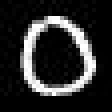

In [52]:
training_image_dictionary[0][:,:,120] # this is the TRUE image

Next, let's `encode` the true image into the weight matrix $\mathbf{W}$. This is one of the most clever aspects of a [Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network), we don't estimate the model parameters using a technique like [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). Instead, we can analytically learn the parameters without searching for them! Wow!

In [21]:
W = ⊗(true_state,(transpose(true_state) |> vec));

## Task 2: If we start from a random state, do we remember the training image?
Fill me in.

In [23]:
simulation_state = let

    # generate a *random* initial configuration -
    s = Array{Int32,1}(undef, number_of_pixels);
    for i ∈ 1:number_of_pixels
        if (rand() ≤ 0.5)
            s[i] = -1;
        else
            s[i] = 1;
        end
    end

    for i ∈ 1:number_of_simulation_steps

        j = rand(1:number_of_pixels); # generate a random index
        tmp = 0.0;
        for k ∈ 1:number_of_pixels
            tmp += W[j,k]*s[k];
        end
        s[j] = sign(tmp - α[j]);
    end

    s;
end;

In [24]:
simulation_state

784-element Vector{Int32}:
  1
  1
  1
  1
  1
  1
  1
  1
 -1
  1
 -1
 -1
  1
  ⋮
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1

What does the reconstructed image look like? 

In [26]:
reconstructed_image = let

    reconstructed_image = Array{Int32,2}(undef, number_of_rows, number_of_cols);
    linearindex = 1;
    for row ∈ 1:28
        for col ∈ 1:28

            s = simulation_state[linearindex];
            if (s == -1)
                reconstructed_image[row,col] = 0;
            else
                reconstructed_image[row,col] = 1;
            end
            linearindex+=1;
        end
    end
    
    reconstructed_image
end

28×28 Matrix{Int32}:
 1  1  1  1  1  1  1  1  0  1  0  0  1  …  1  1  1  0  1  1  1  0  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  0  0  1     1  0  1  1  0  0  1  0  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     0  1  1  1  0  1  1  0  1  1  1  1
 1  1  1  1  1  1  1  1  0  1  1  1  0     1  0  0  0  0  0  0  1  1  1  1  1
 1  1  1  1  1  1  1  1  0  1  0  0  0     0  0  0  0  0  1  1  0  1  1  1  1
 1  1  1  1  1  1  1  1  0  1  0  0  1  …  0  0  0  0  0  0  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  0  1  0  1  1     0  0  0  0  0  0  1  0  1  1  1  1
 1  1  1  1  1  1  1  1  0  1  0  1  0     0  0  0  0  0  0  0  1  1  1  1  1
 1  0  0  1  1  0  0  0  1  0  1  0  0     0  0  0  0  0  0  1  0  1  1  1  1
 1  0  0  0  1  1  0  1  1  1  0  0  0     1  0  0  0  0  0  0  0  1  1  1  1
 0  1  1  0  0  1  0  1  0  0  0  0  0  …  1  0  0  0  0  0  1  1  1  1  1  1
 0  1  1  0  1  0  1  0  0  0  0  0  0     1  1  0  0  0  0  0  0  1  1  1  1
 1  0  0  1  1  0  1  0  0  0  0  0  1     

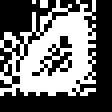

In [50]:
Gray.(1 .- reconstructed_image)